### 1. CNN training

The following code section will load the dataset from a folder that you specify. You may change the batch sizes and add additional data augmentation steps here if you wish.

In [824]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import os
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# Setting the seed
seed_value = 3
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

data_dir   = 'scene32' # SPECIFY YOUR PATH TO THE DATASET
batch_size = 40

# Data generator for training
# Additional data augmentation may be added here if desired
train_datagen        = ImageDataGenerator(
    rescale          = 1./255,
    horizontal_flip  = True,
    brightness_range = (0.5, 1.5),
    rotation_range   = (15))

# Data generator for test
# DO NOT USE DATA AUGMENTATION WITH TEST SET
test_datagen = ImageDataGenerator(
    rescale  =1./255)

# Generate training data from 'train' directory
train_data = train_datagen.flow_from_directory(
        data_dir + '/train',
        target_size = (32,32),
        batch_size  = batch_size,
        class_mode  = 'categorical')

# Generate vaildation data from 'valid' directory
val_data = test_datagen.flow_from_directory(
        data_dir + '/valid',
        target_size = (32,32),
        batch_size  = batch_size,
        class_mode  = 'categorical')

# Generate test data from 'test' directory
test_data = test_datagen.flow_from_directory(
        data_dir + '/test',
        target_size = (32,32),
        batch_size  = batch_size,
        class_mode  = 'categorical',
        shuffle     = False)

# Output list of class names
class_names_and_indices = train_data.class_indices
print(class_names_and_indices)

# Note: To train a model with the dataset loaded above, pass the train and val
# datasets to the fit() function, like so:
# myModel.fit(train_data, validation_data=val_data, ...)

Found 1440 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}


Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



In [825]:
# Create the CNN model
cnn = keras.Sequential(
    [
        layers.Input((32, 32, 3)),
        layers.Conv2D(16, (3, 3), activation = 'relu'), 
        layers.Conv2D(16, (3, 3), activation = 'relu'), 
        layers.MaxPooling2D((2, 2)), 
        layers.Flatten(),
        layers.Dense(64, activation = 'relu'),   
        layers.Dense(8, activation = 'softmax')
    ], 
)

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



In [826]:
# Compiling as per instructions
cnn.compile(optimizer = 'adam',
            loss      = tf.keras.losses.CategoricalCrossentropy(from_logits = False),
            metrics   = ['accuracy'])

In [827]:
# Early stopping to find number of epochs
early_stopping = EarlyStopping(monitor              = 'val_loss', 
                               patience             = 3, 
                               restore_best_weights = True)  

# Train the model with early stopping
model = cnn.fit(train_data, 
                batch_size            = batch_size, 
                epochs                = 50, 
                validation_data       = val_data, 
                validation_batch_size = batch_size, 
                callbacks             = [early_stopping])

Epoch 1/50
36/36 [==============================] - 2s 45ms/step - loss: 2.0428 - accuracy: 0.2139 - val_loss: 1.9225 - val_accuracy: 0.2188
Epoch 2/50
36/36 [==============================] - 1s 39ms/step - loss: 1.7807 - accuracy: 0.3528 - val_loss: 1.6704 - val_accuracy: 0.4031
Epoch 3/50
36/36 [==============================] - 1s 37ms/step - loss: 1.5628 - accuracy: 0.4597 - val_loss: 1.5431 - val_accuracy: 0.4750
Epoch 4/50
36/36 [==============================] - 1s 37ms/step - loss: 1.4305 - accuracy: 0.5333 - val_loss: 1.3733 - val_accuracy: 0.5437
Epoch 5/50
36/36 [==============================] - 1s 36ms/step - loss: 1.3030 - accuracy: 0.5569 - val_loss: 1.3366 - val_accuracy: 0.5000
Epoch 6/50
36/36 [==============================] - 1s 37ms/step - loss: 1.2215 - accuracy: 0.6021 - val_loss: 1.2226 - val_accuracy: 0.5906
Epoch 7/50
36/36 [==============================] - 1s 38ms/step - loss: 1.1006 - accuracy: 0.6354 - val_loss: 1.1625 - val_accuracy: 0.5938
Epoch 8/50
36

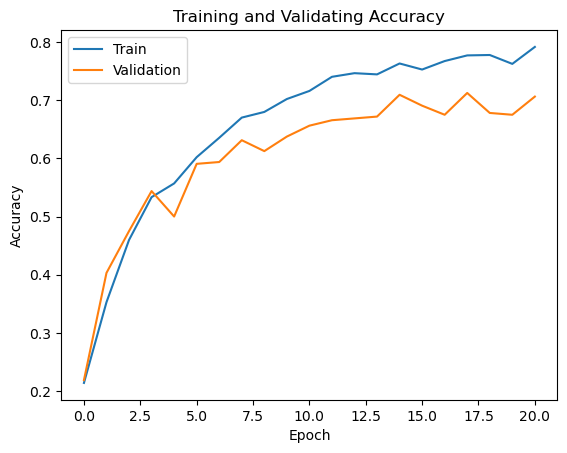

In [828]:
# Plotting the training and validation accuracy
plt.plot(model.history['accuracy'], label = 'Train')
plt.plot(model.history['val_accuracy'], label = 'Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validating Accuracy')
plt.legend()
plt.savefig("Training and Validating Accuracy.png")
plt.show()

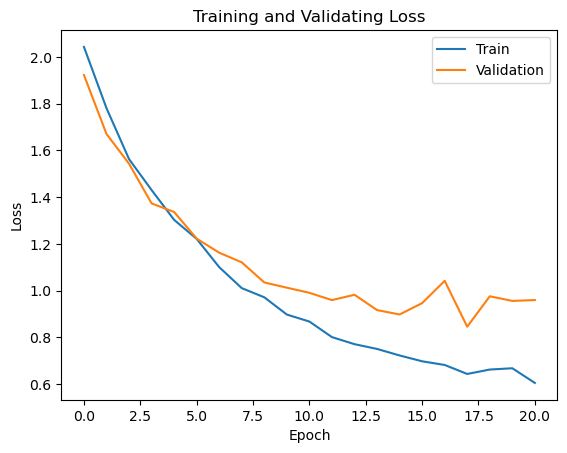

In [829]:
# Plotting the training and validation loss
plt.plot(model.history['loss'], label = 'Train')
plt.plot(model.history['val_loss'], label = 'Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validating Loss')
plt.legend()
plt.savefig("Training and Validating Loss.png")
plt.show()

### 2. Error anaylsis

In [830]:
# Functions taken from week 6 workshop
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
 
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# Define a function to create a superimposed visualization
def display_gradcam(img_name, heatmap, reference, title, alpha = 0.4):

    # Load the original image
    img = image.load_img(img_name)
    img = image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors  = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
 
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(load_img(img_name, target_size = (32, 32)))
    plt.gca().set_title("Original " + title)
    plt.axis('off')
    
    # Display superimpose result
    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.gca().set_title('Superimposed ' + title)
    plt.axis('off')
    plt.savefig(reference + ".png")
    plt.show()
    

# Define a function to process the input image
def get_img_array(img_path, size):
    img   = image.load_img(img_path, target_size = size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis = 0)
    return array

### Test the model on the provided test data

In [831]:
test_results = cnn.evaluate(test_data, batch_size = batch_size)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

8/8 [==============================] - 0s 12ms/step - loss: 0.7132 - accuracy: 0.7688
Test results - Loss: 0.7131557464599609 - Accuracy: 0.768750011920929%


In [832]:
# Get the correct labels for the test data
truth = test_data.classes

# Make predictions on the test data
predictions = cnn.predict(test_data)

# Calculate accuracy per class
num_classes    = len(class_names_and_indices)
accuracy = {}
right    = {}
wrong    = {}

for class_id, class_name in class_names_and_indices.items():
    class_index       = np.where(truth == class_name)[0]
    class_truth       = truth[class_index]
    class_prediction  = np.argmax(predictions[class_index], axis=1)
    
    accuracy[class_id] = np.mean(class_prediction == class_truth)
    
    # Identify misclassified images for the current class
    right_index = class_index[class_prediction == class_truth]
    wrong_index = class_index[class_prediction != class_truth]

    
    # Store misclassified indices in the misclassified_images dictionary
    right[class_id] = right_index
    wrong[class_id] = [(i, class_prediction[i%len(class_prediction)]) for i in (wrong_index)]
    
    print(f'\"{class_id}\" Classification Accuracy = {accuracy[class_id]}%')

# Calculate overall accuracy
overall_accuracy = np.mean(np.argmax(predictions, axis = 1) == truth)
print("\n")
print(f'Overall Classification Accuracy = {overall_accuracy}%')

8/8 [==============================] - 0s 9ms/step
"coast" Classification Accuracy = 0.8%
"forest" Classification Accuracy = 0.75%
"highway" Classification Accuracy = 0.825%
"insidecity" Classification Accuracy = 0.675%
"mountain" Classification Accuracy = 0.725%
"opencountry" Classification Accuracy = 0.625%
"street" Classification Accuracy = 0.825%
"tallbuilding" Classification Accuracy = 0.925%


Overall Classification Accuracy = 0.76875%


### Obtaining the misclassified and correctly classified images for the lowest performing class (opencountry)

"opencountry" Correctly Classified Count: 25
"opencountry" Misclassified Count: 15


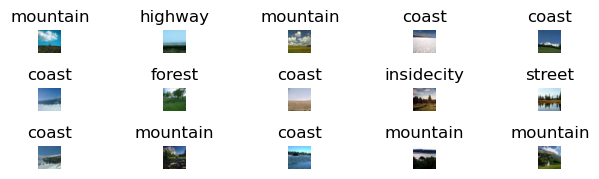

In [833]:
misclassified = []
classified    = []

# Correctly classified
for class_id, index in right.items():
    
    if class_id != "opencountry":
        continue
    
    title = "opencountry"
    # Prints the number of correctly classified images for the class
    print(f'\"{class_id}\" Correctly Classified Count: {len(index)}')
    

    # Adds the image to classified
    for i in range(len(index)):
        img = load_img(test_data.filepaths[index[i]], target_size=(32, 32))
        img = img_to_array(img)
        classified.append((index[i], title))

# Misclassified
for class_id, index in wrong.items():
    
    if class_id != "opencountry":
        continue
    
    # Prints the number of missclassified images for the class
    print(f'\"{class_id}\" Misclassified Count: {len(index)}')
    

    # Prints the missclassified images into a subplot
    for i in range(len(index)):
        plt.subplot(8, 5, i + 1)
        img = load_img(test_data.filepaths[index[i][0]], target_size=(32, 32))
        img = img_to_array(img)
        
        plt.imshow(img/255) # normalising
        title = ""
        for key1, val1 in class_names_and_indices.items():
            if val1 == index[i][1]:
                title = key1
        plt.gca().set_title(title)
        misclassified.append((index[i][0], title))
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("opencountry Misclassified.png")
    plt.show()

### Comparing opencountry and coast  

/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


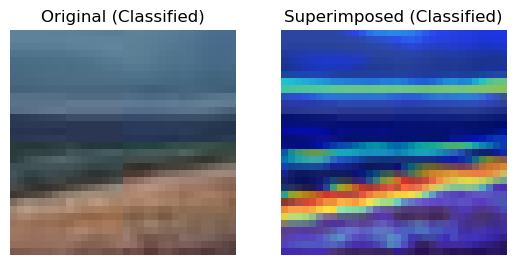

/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:33: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


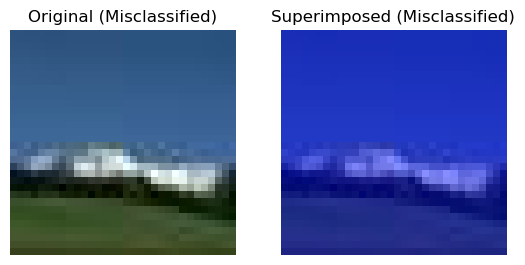

In [844]:
last_conv_layer_name = cnn.layers[1].name

# Heatmap for classified opencountry
img_name  = test_data.filepaths[classified[6][0]]
img_array = preprocess_input(get_img_array(img_name, size = (32,32)))
heatmap   = make_gradcam_heatmap(img_array, cnn, last_conv_layer_name)
display_gradcam(img_name, heatmap,"opencountry","(Classified)", alpha = 0.8)

# Heatmap for misclassified opencountry
img_name  = test_data.filepaths[misclassified[4][0]]
img_array = preprocess_input(get_img_array(img_name, size = (32,32)))
heatmap   = make_gradcam_heatmap(img_array, cnn, last_conv_layer_name)
display_gradcam(img_name, heatmap,"coast", "(Misclassified)", alpha = 0.8)

"coast" Correctly Classified Count: 32


/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:33: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


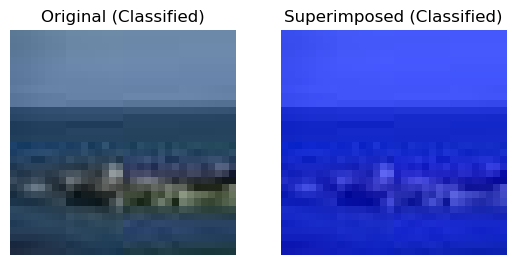

In [854]:
# Correctly classified coast
classified_coast = []
for class_id, index in right.items():
    
    if class_id != "coast":
        continue
    
    title = "coast"
    # Prints the number of missclassified images for the class
    print(f'\"{class_id}\" Correctly Classified Count: {len(index)}')
    

    # Prints the missclassified images into a subplot
    for i in range(len(index)):
        img = load_img(test_data.filepaths[index[i]], target_size=(32, 32))
        img = img_to_array(img)
        classified_coast.append((index[i], title))
        
# Heatmap for classified coast
img_name  = test_data.filepaths[classified_coast[3][0]]
img_array = preprocess_input(get_img_array(img_name, size = (32,32)))
heatmap   = make_gradcam_heatmap(img_array, cnn, last_conv_layer_name)
display_gradcam(img_name, heatmap,"trueCoast", "(Classified)", alpha = 0.8)

### Comparing opencountry and forest 

/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:33: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


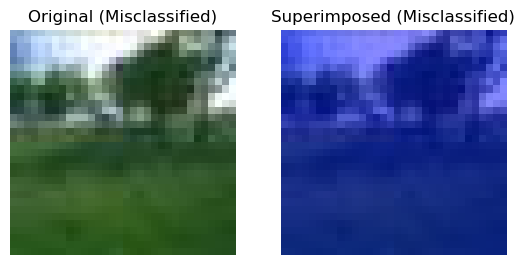

In [855]:
# Heatmap for misclassified opencountry
img_name  = test_data.filepaths[misclassified[6][0]]
img_array = preprocess_input(get_img_array(img_name, size = (32,32)))
heatmap   = make_gradcam_heatmap(img_array, cnn, last_conv_layer_name)
display_gradcam(img_name, heatmap, "forest", "(Misclassified)", alpha = 0.8)

### Comparing opencountry and highway 

/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:33: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


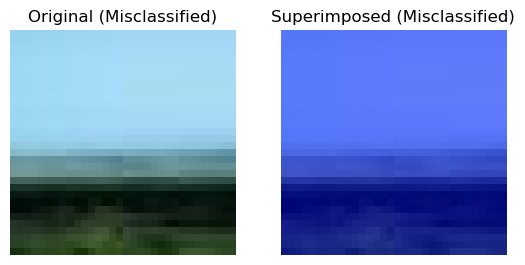

In [856]:
# Heatmap for misclassified opencountry
img_name  = test_data.filepaths[misclassified[1][0]]
img_array = preprocess_input(get_img_array(img_name, size = (32,32)))
heatmap   = make_gradcam_heatmap(img_array, cnn, last_conv_layer_name)
display_gradcam(img_name, heatmap, "highway", "(Misclassified)", alpha = 0.8)

### Comparing opencountry and insidecity

/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:33: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


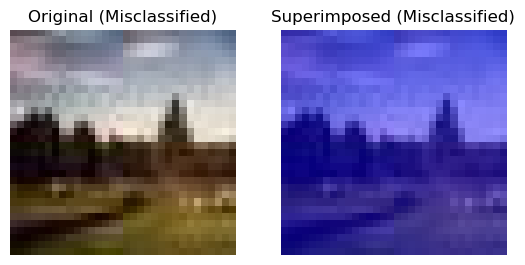

In [857]:
# Heatmap for misclassified opencountry
img_name  = test_data.filepaths[misclassified[8][0]]
img_array = preprocess_input(get_img_array(img_name, size = (32,32)))
heatmap   = make_gradcam_heatmap(img_array, cnn, last_conv_layer_name)
display_gradcam(img_name, heatmap, "insidecity", "(Misclassified)", alpha = 0.8)

### Comparing opencountry and  mountain

/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:33: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


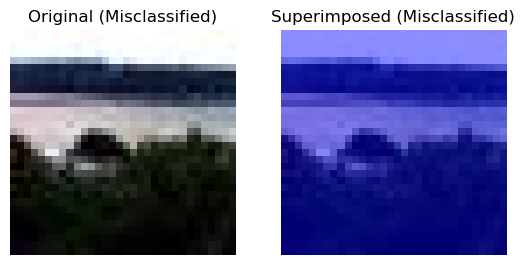

In [862]:
# Heatmap for misclassified opencountry
img_name  = test_data.filepaths[misclassified[13][0]]
img_array = preprocess_input(get_img_array(img_name, size = (32,32)))
heatmap   = make_gradcam_heatmap(img_array, cnn, last_conv_layer_name)
display_gradcam(img_name, heatmap, "mountain", "(Misclassified)", alpha = 0.8)

### Comparing Opencountry and street

/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:33: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
/var/folders/g9/3p7gtpl55tx62yp9kyx5_vd80000gn/T/ipykernel_74391/873834316.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


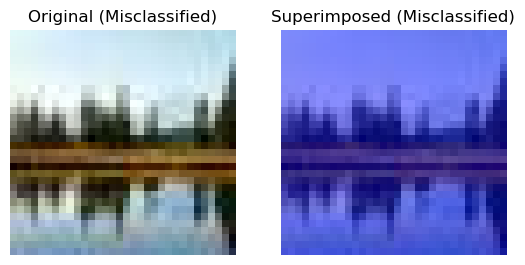

In [859]:
# Heatmap for misclassified opencountry
img_name  = test_data.filepaths[misclassified[9][0]]
img_array = preprocess_input(get_img_array(img_name, size = (32,32)))
heatmap   = make_gradcam_heatmap(img_array, cnn, last_conv_layer_name)
display_gradcam(img_name, heatmap, "street", "(Misclassified)", alpha = 0.8)

### 3. Kernel engineering

In [865]:
k_val     = 10
results   = {}
visualize = {}

for k in range(3, k_val + 1):    
    # Create the CNN model
    cnn2 = keras.Sequential(
        [
            layers.Input((32, 32, 3)),
            layers.Conv2D(16, (k, k), activation = 'relu'), 
            layers.MaxPooling2D((2, 2)), 
            layers.Flatten(),
            layers.Dense(64, activation = 'relu'),   
            layers.Dense(8, activation = 'softmax')
        ], 
    )

    cnn2.compile(optimizer = 'adam',
                 loss      = tf.keras.losses.CategoricalCrossentropy(from_logits = False),
                 metrics   = ['accuracy'])


    model2 = cnn2.fit(train_data, 
                      batch_size            = batch_size, 
                      epochs                = 21,         #same number preserved from question 1
                      validation_data       = val_data, 
                      validation_batch_size = batch_size)

    # Test the model on the test data provided
    test_results2 = cnn2.evaluate(test_data, batch_size = batch_size)
    results[k]    = test_results2
    
    # Getting the kernel visualisation (Code adapted form week 6 workshop)
    filters, biases = cnn2.layers[0].get_weights()

    # Normalize filter values and store them
    f_min, f_max = filters.min(), filters.max()
    filters      = (filters - f_min) / (f_max - f_min)
    visualize[k] = filters

Epoch 1/21
36/36 [==============================] - 1s 37ms/step - loss: 1.9123 - accuracy: 0.2681 - val_loss: 1.7395 - val_accuracy: 0.3906
Epoch 2/21
36/36 [==============================] - 1s 39ms/step - loss: 1.5987 - accuracy: 0.4493 - val_loss: 1.5197 - val_accuracy: 0.4656
Epoch 3/21
36/36 [==============================] - 1s 34ms/step - loss: 1.4744 - accuracy: 0.5083 - val_loss: 1.4286 - val_accuracy: 0.4906
Epoch 4/21
36/36 [==============================] - 1s 33ms/step - loss: 1.4058 - accuracy: 0.5160 - val_loss: 1.3748 - val_accuracy: 0.5125
Epoch 5/21
36/36 [==============================] - 1s 33ms/step - loss: 1.3029 - accuracy: 0.5826 - val_loss: 1.3088 - val_accuracy: 0.5469
Epoch 6/21
36/36 [==============================] - 1s 34ms/step - loss: 1.2747 - accuracy: 0.5688 - val_loss: 1.2692 - val_accuracy: 0.5781
Epoch 7/21
36/36 [==============================] - 1s 34ms/step - loss: 1.2046 - accuracy: 0.6021 - val_loss: 1.2743 - val_accuracy: 0.5625
Epoch 8/21
36

Epoch 16/21
36/36 [==============================] - 1s 33ms/step - loss: 0.7091 - accuracy: 0.7701 - val_loss: 0.8621 - val_accuracy: 0.6938
Epoch 17/21
36/36 [==============================] - 1s 34ms/step - loss: 0.6842 - accuracy: 0.7611 - val_loss: 0.8442 - val_accuracy: 0.7125
Epoch 18/21
36/36 [==============================] - 1s 34ms/step - loss: 0.6725 - accuracy: 0.7569 - val_loss: 0.8928 - val_accuracy: 0.7063
Epoch 19/21
36/36 [==============================] - 1s 33ms/step - loss: 0.6836 - accuracy: 0.7701 - val_loss: 0.9188 - val_accuracy: 0.7063
Epoch 20/21
36/36 [==============================] - 1s 34ms/step - loss: 0.6616 - accuracy: 0.7806 - val_loss: 0.8837 - val_accuracy: 0.7000
Epoch 21/21
8/8 [==============================] - 0s 11ms/step - loss: 0.8489 - accuracy: 0.7437
Epoch 1/21
36/36 [==============================] - 1s 35ms/step - loss: 1.9639 - accuracy: 0.2479 - val_loss: 1.8136 - val_accuracy: 0.3281
Epoch 2/21
36/36 [==============================] -

36/36 [==============================] - 1s 39ms/step - loss: 0.9784 - accuracy: 0.6771 - val_loss: 1.1475 - val_accuracy: 0.6000
Epoch 10/21
36/36 [==============================] - 1s 37ms/step - loss: 0.9788 - accuracy: 0.6819 - val_loss: 1.0992 - val_accuracy: 0.5875
Epoch 11/21
36/36 [==============================] - 1s 34ms/step - loss: 0.9602 - accuracy: 0.6882 - val_loss: 1.0413 - val_accuracy: 0.6438
Epoch 12/21
36/36 [==============================] - 1s 35ms/step - loss: 0.9618 - accuracy: 0.6833 - val_loss: 1.0513 - val_accuracy: 0.6219
Epoch 13/21
36/36 [==============================] - 1s 34ms/step - loss: 0.9277 - accuracy: 0.6917 - val_loss: 1.0649 - val_accuracy: 0.6313
Epoch 14/21
36/36 [==============================] - 1s 34ms/step - loss: 0.8939 - accuracy: 0.6958 - val_loss: 1.0652 - val_accuracy: 0.6531
Epoch 15/21
36/36 [==============================] - 1s 34ms/step - loss: 0.8629 - accuracy: 0.7188 - val_loss: 1.0105 - val_accuracy: 0.6594
Epoch 16/21
36/36 

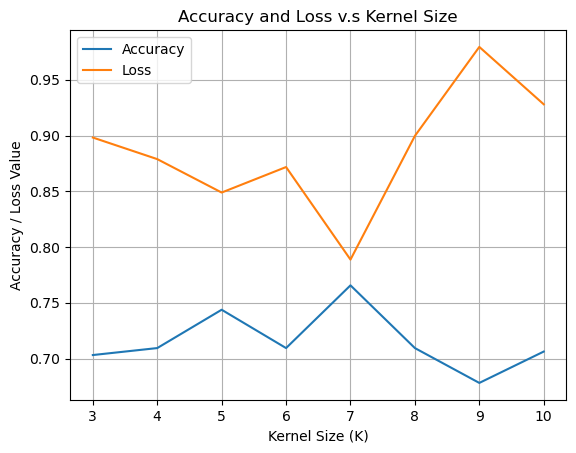

In [866]:
# Plotting accuracy and loss for each kernel value for the test set
y_accuracy = []
y_loss     = []
x          = [i for i in range(3, k_val+1)]
for key, value in results.items():
    y_accuracy.append(value[1])
    y_loss.append(value[0])

plt.plot(x, y_accuracy, label = "Accuracy")
plt.plot(x, y_loss, label = "Loss")
plt.xlabel('Kernel Size (K)')
plt.ylabel('Accuracy / Loss Value')
plt.title('Accuracy and Loss v.s Kernel Size')
plt.legend()
plt.grid(True)
plt.savefig("Q3AnL.png")
plt.show()

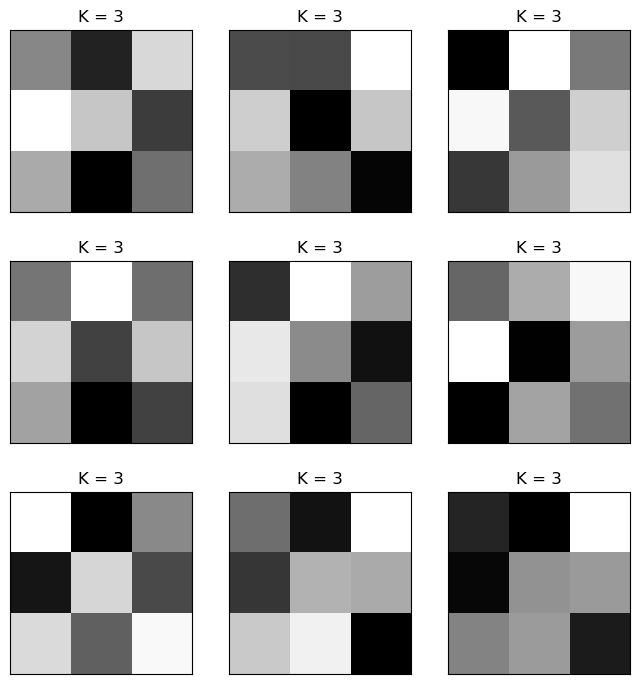

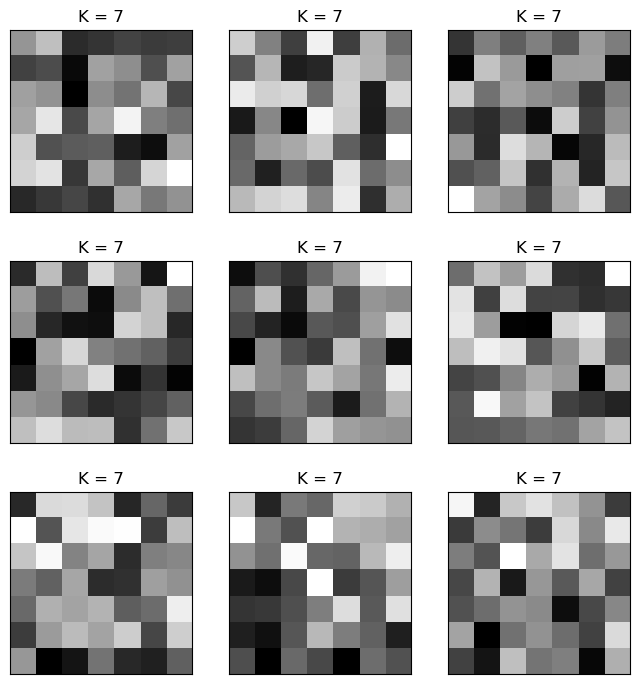

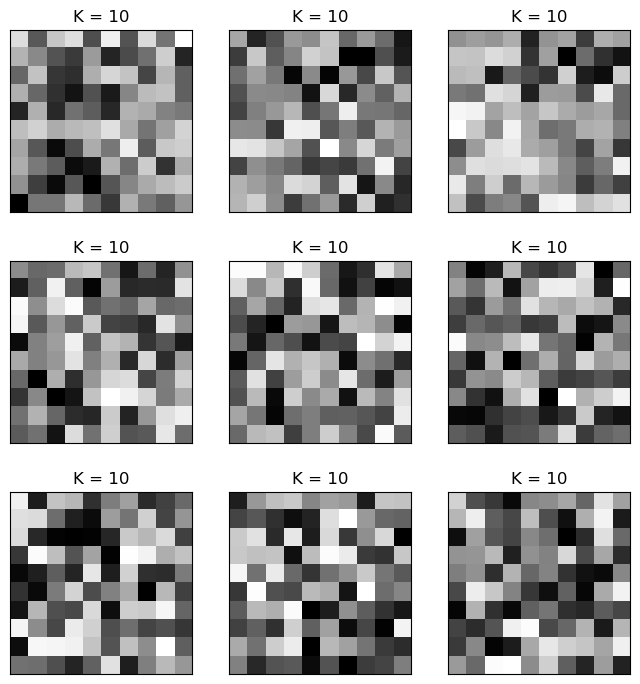

In [894]:
# Code adapted from week 6 workshop
# Plot first 3 filters per channel
for key, filters in visualize.items():
    
    # filter out only the base, optimal and overfitted K values
    if key not in [3, 7, 10]:
        continue
    
    fig       = plt.figure(figsize = (8, 12))
    n_filters = 3
    ix        = 1
    
    for i in range(n_filters):
        # Get the filter
        f = filters[:, :, :, i]
        # Plot each channel separately
        for j in range(3):
            ax = plt.subplot(n_filters, 3, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("K = " + str(key))
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap = 'gray')
            ix += 1
    # Plot the filters
    plt.subplots_adjust(wspace=0.2, hspace=-0.5)
    plt.savefig("Q3K" + str(key) + ".png")
    plt.show()